# 0 Table of Contents

1. [Setup](#1-setup)
    1. [Import](#11-imports)
    2. [Resources](#12-resources)
    3. [Load Data](#13-load-data)
2. [Prepare Data](#2-prepare-data)
3. [Hypothesis - freight_value](#3-hypothesis---freight_value)
4. [Modelling (Linear Regression)](#4-modelling-linear-regression)
    1. [Split Data](#41-simple-linear-regression)
    2. [Build Model](#42-other-variable-pairs)
    3. [Assess Model](#43-multi-linear-regression)
    4. [Evaluate Results](#44-visualize-prediction-outcome)

# 1 Setup [(#)](#0-table-of-contents)

## 1.1 Imports [(#)](#0-table-of-contents)

In [23]:
import sys
import os
from  pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sys.path.insert(0, r"C:\Users\vynde\PycharmProjects\dataanalysis")
import databridger as da 

## 1.2 Resources [(#)](#0-table-of-contents)

In [2]:
raw_data_folder = Path('..') / 'data' / 'raw'
report_folder = Path('..') / 'reports'

## 1.3 Load Data [(#)](#0-table-of-contents)

Load database with databriger

In [3]:
db_csv = da.Database(raw_data_folder)

Convert datetime variables

In [4]:
for key in db_csv.tables:
    for column in db_csv.tables[key].columns:
        if db_csv.tables[key][column].dtype == 'object':
            if all(db_csv.tables[key][column].str.match(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}")):
                db_csv.tables[key][column] = pd.to_datetime(db_csv.tables[key][column])
                print(f"converted:   {key:15} / {column:30} from object to {db_csv.tables[key][column].dtype}")

converted:   olist_orders_dataset / order_purchase_timestamp       from object to datetime64[ns]
converted:   olist_orders_dataset / order_approved_at              from object to datetime64[ns]
converted:   olist_orders_dataset / order_delivered_carrier_date   from object to datetime64[ns]
converted:   olist_orders_dataset / order_delivered_customer_date  from object to datetime64[ns]
converted:   olist_orders_dataset / order_estimated_delivery_date  from object to datetime64[ns]
converted:   olist_order_items_dataset / shipping_limit_date            from object to datetime64[ns]
converted:   olist_order_reviews_dataset / review_creation_date           from object to datetime64[ns]
converted:   olist_order_reviews_dataset / review_answer_timestamp        from object to datetime64[ns]


Rename tables

In [5]:
table_names = list(db_csv.tables.keys())

# remove 'olist_' and '_dataset' in table_names
new_table_names = (
    list(map(
        lambda x: x.removeprefix("olist_").removesuffix("_dataset"), 
        table_names
    ))
)

# overwrite table names in db_csv
db_csv.tables = dict(zip(new_table_names, db_csv.tables.values()))

Overview

In [6]:
db_csv.update_columns_mapping(["geolocation_zip_code_prefix"])

Column and table mappings need to be corrected. Current implementation of the Database class for csv files does not construct a compatible columns_mapping for using its easy_merge method.

Therefore, table-column-pairs just need to be swapped and concatenated

In [7]:
# original mapping
df1 = db_csv.columns_mapping[["from_table", "from_column", "to_table", "to_column"]]
# swapped version
df2 = db_csv.columns_mapping[["to_table", "to_column", "from_table", "from_column"]]

# Renaming columns to match the df1's columns
df2.columns = ["from_table", "from_column", "to_table", "to_column"]

# new mapping
adjusted_columns_mapping = pd.concat([df1, df2], ignore_index=True).drop_duplicates()

# apply the new mapping to the Database instance
db_csv.columns_mapping = adjusted_columns_mapping

# this is copy/pasted from the Database class directly
db_csv.table_mapping = dict(db_csv.columns_mapping[["from_table", "to_table"]].groupby("from_table")["to_table"].apply(list))

# 2 Prepare Data [(#)](#0-table-of-contents)

Merge tables into one dataframe

In [8]:
table_names = ["orders", "order_items", "order_payments", "order_reviews", "products", "sellers", "customers"]
tables = [db_csv.tables[table_name] for table_name in table_names]

for table in tables:
    print(table.shape, table.columns.tolist())

df = tables[0]
for table in tables[1:]:
    df = df.merge(table, how="outer")

print(df.shape)

(99441, 8) ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
(112650, 7) ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
(103886, 5) ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
(99224, 7) ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
(32951, 9) ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
(3095, 4) ['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']
(99441, 5) ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
(119143, 39)


Add some more columns

In [9]:
# track count if internal ids per order
df["order_numitems"] = df.groupby("order_id")["order_item_id"].transform("max")
df["order_numpayments"] = df.groupby("order_id")["payment_sequential"].transform("max")

# products
df["total_products_sold"] = df.groupby(["product_id", "order_item_id", "payment_sequential"]).transform("size")
da.wrangle.create_flag(df, col="total_products_sold", flag_col="total_products_sold_cat", 
    limits=[10, 200, 400], labels=["rarely_sold", "commonly_sold", "frequently_sold", "top_seller"])
df["avg_products_price"] = df.groupby(["product_id", "order_item_id", "payment_sequential"])["price"].transform("mean")
da.wrangle.create_flag(df, col="avg_products_price", flag_col="avg_products_price_cat", 
    limits=[1, 100, 1000], labels=["cheap", "low_priced", "high_priced", "expensive"])

# payment
df["order_payment"] = df.groupby(["order_id", "order_item_id"])["payment_value"].transform("sum")

# order items
df["order_price"] = df.groupby(["order_id", "payment_sequential"])["price"].transform("sum")
df["order_freight"] = df.groupby(["order_id", "payment_sequential"])["freight_value"].transform("sum")

# orders
df["time_to_approve"] = df["order_approved_at"] - df["order_purchase_timestamp"]
df["time_to_carrier"] = df["order_delivered_carrier_date"] - df["order_purchase_timestamp"]
df["time_to_customer"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
da.wrangle.create_flag(df, col="time_to_customer", flag_col="time_to_customer_cat", 
    limits=[1, 10, 30], labels=["max1day", "max10days", "max30days", "upto209"])
df["time_to_customer_est"] = df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]

# seller
df["state_numsellers"] = df.groupby(["seller_state"]).transform("size")

Extract only columns that are numeric in nature

In [106]:
df_numeric = df[[
    'price', 'freight_value', 'payment_sequential', 'payment_installments',
    'payment_value', 'review_score', 'product_name_lenght',
    'product_description_lenght', 'product_photos_qty', 'product_weight_g',
    'product_length_cm', 'product_height_cm', 'product_width_cm',
    'order_numitems', 'order_numpayments', 'total_products_sold',
    'avg_products_price', 'order_payment', 'order_price', 'order_freight',
    'time_to_customer'
]].dropna()

# 3 Hypothesis - `freight_value` [(#)](#0-table-of-contents)

It's intuitive that Linear Regressions perform best of there is a linear correlation between independant and dependant variable. Back in step 2 of this analysis we calculated a correlation matrix. The variables freight and weight had a decent correlation coefficient. Let's see how LR performs.

Hypothesis: **If the weight increases, freight values increase as well.**

# 4 Modelling [(#)](#0-table-of-contents)

## 4.1 Simple Linear Regression [(#)](#0-table-of-contents)

Select Data

In [160]:
y = df_numeric["freight_value"].values
X = df_numeric["product_weight_g"].values
X.shape

(113231,)

Function that performes Linear Regression:
1. Split Data
2. Build Model
3. Assess Model

In [185]:
def lin_reg(X, y, print_result=False, output=["r2"]) -> float:
    """Performs Linear Regression and returns the r2 score.
    
    X: numpy 1d or 2d array
    y: numpy 1d array

    print_result (optional): prints slope, mean squared error and r2 score of True. Default: False
    output (optional): list or local variables to be returned (bad practice but it works) 
    """
    
    X = X.reshape(-1, 1) if len(X.shape)==1 else X.T
    y = y.reshape(-1, 1)

    # Split data into a training set and a test set.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Create a regression object.
    regression = LinearRegression()

    # Fit the regression object onto the training set.
    regression.fit(X_train, y_train)

    # Predict the values of y using X.
    y_predicted = regression.predict(X_test)

    # Create objects that contain the model summary statistics.
    rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
    r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

    # Print the model summary statistics. This is where you evaluate the performance of the model.
    if print_result:
        print('Slope:', regression.coef_)
        print('Mean squared error: ', rmse)
        print('R2 score: ', r2)
    
    # Collect output variables
    output_vars = []
    for var in output:
        if var in locals():
            output_vars.append(locals()[var])
        else:
            print(f"'{var}' is not a local variable")
    
    if output_vars:
        return output_vars

In [162]:
lin_reg(X, y, True);

Slope: [[0.00260108]]
Mean squared error:  145.78288360139481
R2 score:  0.3576551879354529


**Model Evaluation**

The low R2 score indicates that linear regression is not suitable as a prediction model here.

## 4.2 Other Variable Pairs [(#)](#0-table-of-contents)

Let's examine other pairs of variables of the df_numeric DataFrame. Since we already have a function that performs the analysis and takes pandas Series as inputs, we can simply employ the DataFrame's `corr()` method to test every combination.

This can then be compare to the person correlation matrix

In [163]:
corr_matrix = df_numeric.corr()
r2_matrix = df_numeric.corr(method=lin_reg)

In [132]:
import ipywidgets as widgets

def plot_correlation(selected_matrix):
    plt.figure(figsize=(10, 8))
    
    if selected_matrix == 'LinearRegression R2 Score':
        sns.heatmap(r2_matrix, cmap='coolwarm', center=0)
    else:
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    
    plt.show()

# Create a dropdown widget
matrix_selector = widgets.Dropdown(
    options=['LinearRegression R2 Score', 'Correlation Matrix'],
    description='Select Matrix:',
    disabled=False,
)

# Link the dropdown widget to the plotting function
widgets.interactive(plot_correlation, selected_matrix=matrix_selector)


interactive(children=(Dropdown(description='Select Matrix:', options=('LinearRegression R2 Score', 'Correlatio…

There are some pairs with a pretty good R2 score, but not all them make sense.

By alternating between R2 scores and correlation matrix we see, that the R2 score highly depends on the correlation coeffients. We can even check the correlation between them ...

In [144]:
# Flatten DataFrames
corr_matrix_flat = corr_matrix.to_numpy().flatten()
r2_matrix_flat = r2_matrix.to_numpy().flatten()

# Calculate correlation matrix
np.corrcoef(corr_matrix_flat, r2_matrix_flat)

array([[1.       , 0.9256471],
       [0.9256471, 1.       ]])

... or if linear regression is a good model to predict the R2 score from correlation coefficient

In [141]:
lin_reg(corr_matrix_flat, r2_matrix_flat, print_result=True)

Slope: [[0.80446157]]
Mean squared error:  0.009190450219146903
R2 score:  0.8808087724263373


0.8808087724263373

Yes, it is. 😀

## 4.3 Multi Linear Regression [(#)](#0-table-of-contents)

The product_weight alone wasn't enough to predict the freight_value. Let's see if this works better with more independant variables.

In [192]:
# List of independent variables
independent_vars = ["product_weight_g", "product_width_cm", "price", "time_to_customer"]
dependent_var = "freight_value"

In [193]:
y, *X = df_numeric[[dependent_var, *independent_vars]].values.T
X = np.array(X)

lin_reg(X, y, True)


Slope: [[0.00219626 0.02083096 0.01910198 0.25712304]]
Mean squared error:  127.68772902243522
R2 score:  0.43738559510095865


[0.43738559510095865]

So, we could increase the initial R2 score of 0.358 with more variables to a new score of 0.437.

## 4.4 Visualize Prediction Outcome [(#)](#0-table-of-contents)

In [194]:
y_test, y_predicted = lin_reg(X, y, output=["y_test", "y_predicted"])

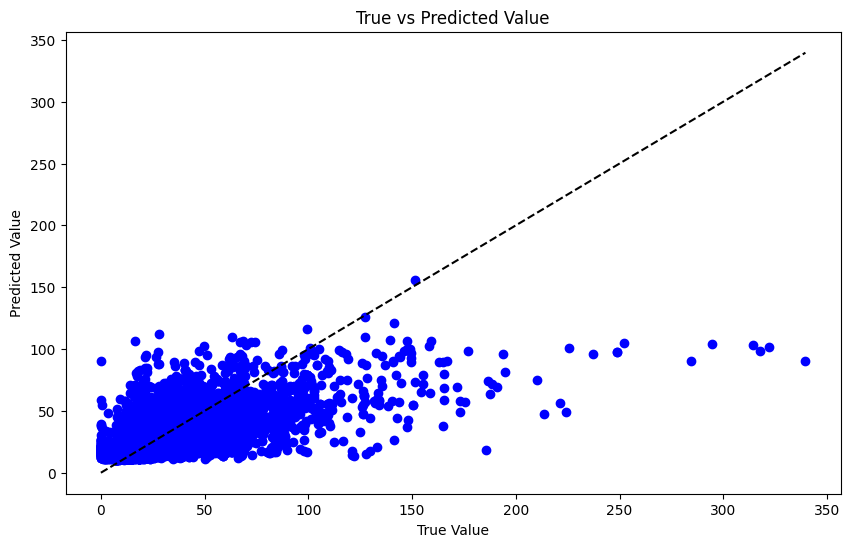

In [195]:
# Plot the actual vs predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_predicted, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('True vs Predicted Value')
plt.show()


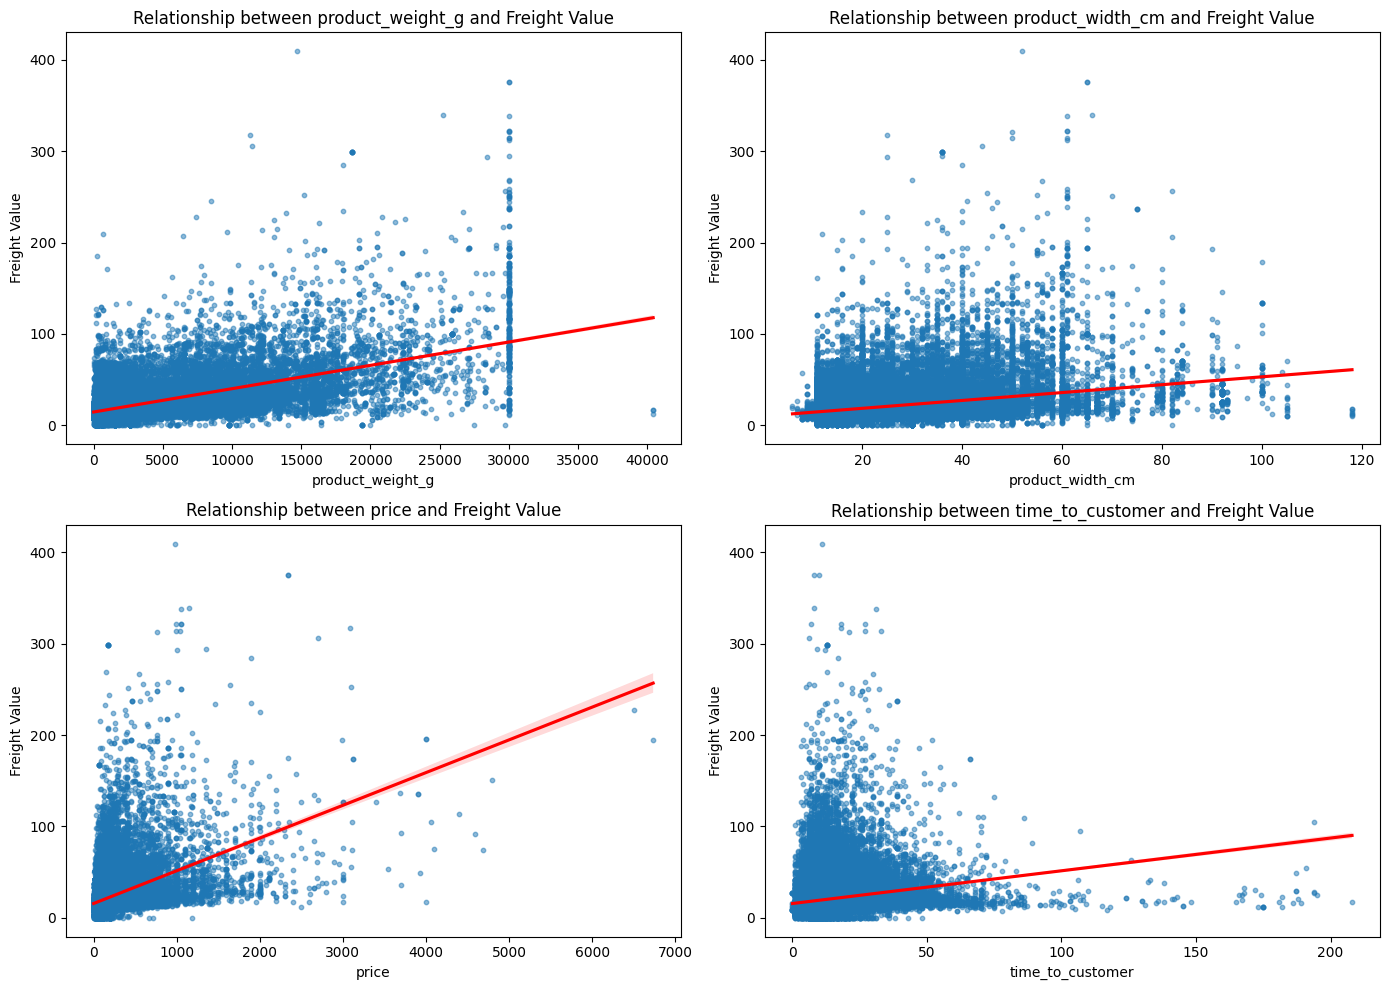

In [196]:
# Create a subplot of 2x2 (adjust as needed)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Loop through each independent variable to create a scatter plot with a regression line
for i, var in enumerate(independent_vars):
    row = i // 2
    col = i % 2
    sns.regplot(data=df_numeric, x=var, y='freight_value', ax=axes[row, col], scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={"color": "red"})
    axes[row, col].set_title(f'Relationship between {var} and Freight Value')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Freight Value')

plt.tight_layout()
plt.show()
